# Image search

指定された画像と似ている画像を検索する。

pytorch:
* https://pytorch.org/

pytorchligtning:
* https://www.pytorchlightning.ai/

faiss:
* https://github.com/facebookresearch/faiss
* https://faiss.ai/

Cifar10:
* https://pytorch.org/vision/stable/datasets.html

AutoEndoder
* https://qiita.com/MuAuan/items/a062d0c245c8f4836399

## Setup for Notebook

In [1]:
# notebook runtime
import sys

runtime = 'local'
if 'google.colab' in sys.modules:
    runtime = 'colab'
elif _dh == ['/kaggle/working']:
    runtime = 'kaggle'
runtime

'colab'

In [2]:
if runtime == 'colab':
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if runtime == 'colab':
    home_path = '/content/drive/MyDrive/image_similarity_search'
else:
    home_path = '/home/jovyan/image_similarity_search'

nbs_path = f'{home_path}/nbs'
datasets_path = f'{home_path}/datasets'
models_path = f'{home_path}/models'
figs_path = f'{home_path}/figs'

In [4]:
%cd {nbs_path}

/content/drive/MyDrive/image_similarity_search/nbs


In [5]:
!pip install -q pytorch_lightning

In [6]:
!pip install -q faiss-gpu

## Configuration

In [7]:
import os
import time
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import pickle
import shutil
from PIL import Image
import glob

In [8]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchsummary import summary

import torchvision
from torchvision import transforms

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

## Dataset

In [11]:
from torchvision.datasets import CIFAR10

In [12]:
dataset_name = 'cifar10'

In [13]:
def clear_datasets():
    path_cifar_10_batches_py = os.path.join(datasets_path, 'cifar-10-batches-py')
    if os.path.exists(path_cifar_10_batches_py):
        shutil.rmtree(path_cifar_10_batches_py)

    path_cifar_10_python = os.path.join(datasets_path, 'cifar-10-python.tar.gz')
    if os.path.exists(path_cifar_10_python):
        os.remove(path_cifar_10_python)

In [14]:
clear_datasets()

In [15]:
class DataModule(pl.LightningDataModule):

    def __init__(self, data_dir: str, batch_size: int=32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = preprocess()
        self.classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
        self.num_classes = len(self.classes)
        self.dims = (3, 32, 32) # channels, width, height

    def prepare_data(self):
        # download
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None): #train, val, testデータ分割
        # Assign train/val datasets for use in dataloaders
        datasets = CIFAR10(self.data_dir, train=True, transform=self.transform)
        n_train = int(len(datasets) * 0.8)
        n_val = len(datasets) - n_train
        self.ds_train, self.ds_val = torch.utils.data.random_split(datasets, [n_train, n_val])
        self.ds_test = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.ds_train, shuffle=True, drop_last=True, batch_size=32, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.ds_val, shuffle=False, batch_size=32, num_workers=0)
 
    def test_dataloader(self):
        return DataLoader(self.ds_test, shuffle=False, batch_size=32, num_workers=0)

In [16]:
def preprocess():
    return transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [17]:
datamodule = DataModule(datasets_path, 32)
datamodule.prepare_data()
datamodule.setup()

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/image_similarity_search/datasets/cifar-10-python.tar.gz to /content/drive/MyDrive/image_similarity_search/datasets
Files already downloaded and verified


In [18]:
# check data size
train_dataloader = iter(datamodule.train_dataloader())
images, labels = next(train_dataloader)
images.shape, labels.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

## Training AutoEncoder

画像の特徴ベクトルを抽出するためAutoEncoder を学習する。

In [19]:
pl.seed_everything(42)

Global seed set to 42


42

In [20]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256)
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

In [21]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 256, out_channels = 16,
                                 kernel_size = 2, stride = 2, padding = 0),
            nn.ConvTranspose2d(in_channels = 16, out_channels = 3,
                                 kernel_size = 2, stride = 2)
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [22]:
decoder = Decoder()
decoder(torch.randn(32, 256, 96, 96)).shape

torch.Size([32, 3, 384, 384])

In [23]:
class LitAutoEncoder(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, "val")

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, "test")
    
    def _common_step(self, batch, batch_idx, stage: str):
        x, y = batch
        loss = F.mse_loss(x, self(x))
        self.log(f"{stage}_loss", loss, on_step=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [24]:
# model
autoencoder = LitAutoEncoder()
autoencoder = autoencoder.to(device)  #for gpu
summary(autoencoder.encoder,(3, 32, 32))
summary(autoencoder.decoder,(256, 8, 8))
summary(autoencoder,(3, 32, 32))
print(autoencoder)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
       BatchNorm2d-4           [-1, 64, 16, 16]             128
            Conv2d-5          [-1, 256, 16, 16]         147,712
              ReLU-6          [-1, 256, 16, 16]               0
         MaxPool2d-7            [-1, 256, 8, 8]               0
       BatchNorm2d-8            [-1, 256, 8, 8]             512
Total params: 150,144
Trainable params: 150,144
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 2.50
Params size (MB): 0.57
Estimated Total Size (MB): 3.08
----------------------------------------------------------------
------------------------------------------

In [25]:
path_encoder = f'{models_path}/{dataset_name}_autoencoder.ckpt'

In [26]:
def clear_autoencoder():
    if os.path.exists(path_encoder):
        os.remove(path_encoder)

In [27]:
# clear_autoencoder()

In [28]:
callbacks = [EarlyStopping(monitor="val_loss")]
trainer = pl.Trainer(gpus=1, callbacks=callbacks)

if not os.path.exists(path_encoder):
    #trainer = pl.Trainer(max_epochs=10, gpus=1)
    trainer.fit(autoencoder, datamodule)
    trainer.save_checkpoint(path_encoder)
else:
    autoencoder = autoencoder.load_from_checkpoint(path_encoder)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [29]:
# functions to show an image
def imshow(img, file=None, title=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    if file:
        plt.savefig(file + '.png')
    plt.show()

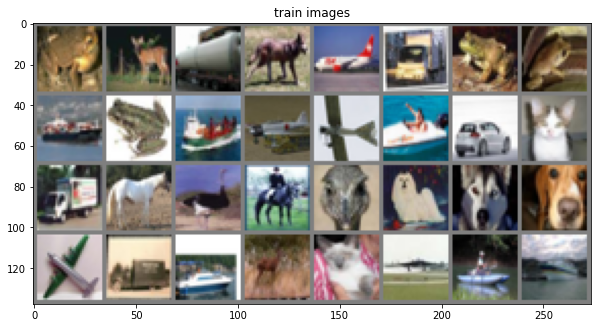

 frog  deer truck   dog plane truck  frog  frog


In [30]:
# Original train images
dataiter = iter(datamodule.train_dataloader())
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images), f'{figs_path}/{dataset_name}_train_original', title='train images')
print(' '.join('%5s' % datamodule.classes[labels[j]] for j in range(8)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


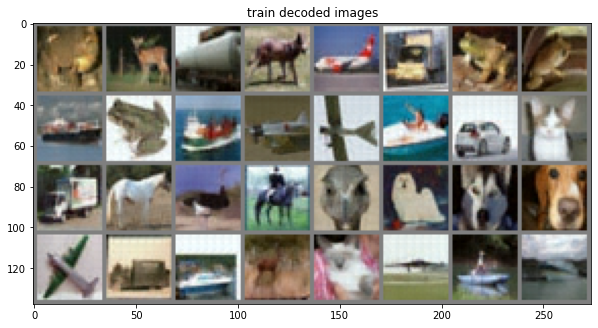

 frog  deer truck   dog plane truck  frog  frog


In [31]:
# Decoded train images
images_hat = autoencoder(images)
imshow(torchvision.utils.make_grid(images_hat), f'{figs_path}/{dataset_name}_train_decoded', title='train decoded images')
print(' '.join('%5s' % datamodule.classes[labels[j]] for j in range(8)))

In [32]:
autoencoder = autoencoder.to(device)  #for gpu
autoencoder.freeze()
autoencoder.eval()

LitAutoEncoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): ConvTranspose2d(256, 16, kernel_size=(2, 2), stride=(2, 2))
      (1): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
    )
  )
)

In [33]:
# Test
# 'test_loss': 0.003598422510549426
results = trainer.test(autoencoder, datamodule)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.004130912479013205, 'test_loss_epoch': 0.004130912479013205}
--------------------------------------------------------------------------------


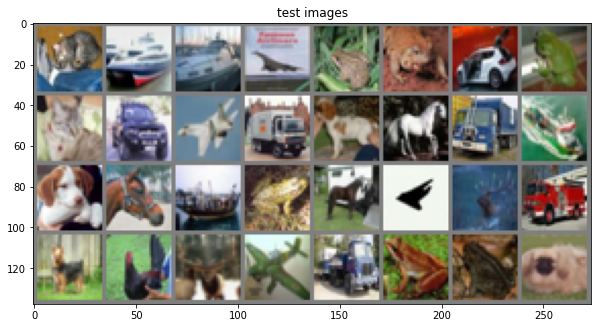

  cat  ship  ship plane  frog  frog   car  frog


In [34]:
# Original test images
dataiter = iter(datamodule.test_dataloader())
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images), f'{figs_path}/{dataset_name}_test_original', title='test images')
print(' '.join('%5s' % datamodule.classes[labels[j]] for j in range(8)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


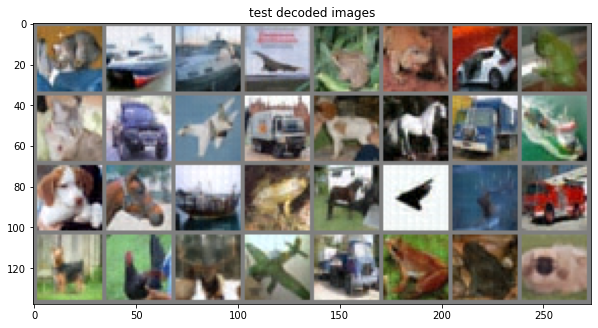

  cat  ship  ship plane  frog  frog   car  frog


In [35]:
images_hat = autoencoder(images)
imshow(torchvision.utils.make_grid(images_hat), f'{figs_path}/{dataset_name}_test_decoded', title='test decoded images')
print(' '.join('%5s' % datamodule.classes[labels[j]] for j in range(8)))

## Embedding

検索対象画像と検索画像を特徴ベクトルへ変換する。

In [36]:
path_embeded_train = f'{models_path}/{dataset_name}_embeded_train.pickle'
path_embeded_test = f'{models_path}/{dataset_name}_embeded_test.pickle'

In [37]:
def clear_embedding():
    if os.path.exists(path_embeded_train):
        os.remove(path_embeded_train)
    if os.path.exists(path_embeded_test):
        os.remove(path_embeded_test)

In [38]:
clear_embedding()

In [39]:
train_dataset = CIFAR10(datasets_path, train=True, download=True)
test_dataset = CIFAR10(datasets_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [40]:
len(train_dataset), len(test_dataset)

(50000, 10000)

In [41]:
# with preprocess
train_dataloader = DataLoader(CIFAR10(datasets_path, train=True, download=True, transform=preprocess()),
                               shuffle=False, batch_size=32, num_workers=0)
test_dataloader = DataLoader(CIFAR10(datasets_path, train=False, download=True, transform=preprocess()),
                               shuffle=False, batch_size=32, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [42]:
len(train_dataloader), len(test_dataloader)

(1563, 313)

In [43]:
def create_embedder_model(autoencoder):
    layers = list(autoencoder.encoder.children())
    #fv = nn.Sequential(nn.AdaptiveMaxPool2d(output_size=1))
    fv = nn.Sequential(nn.Flatten(), nn.Linear(in_features=256*8*8, out_features=256))
    model = nn.Sequential(*layers, *fv)
    return model

In [44]:
embedder = create_embedder_model(autoencoder)
embedder

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=16384, out_features=256, bias=True)
)

In [45]:
img_random = torch.randn(32, 3, 32, 32)
img_emb = embedder(img_random)
img_emb.shape

torch.Size([32, 256])

In [46]:
def get_embeded_vector(embedder, dataloader):
    vector = []
    for i, (images, labels) in enumerate(tqdm(dataloader)):
        with torch.no_grad():
            v = embedder(images).squeeze().cpu()
        vector.extend(v.detach().numpy())

    return vector

In [47]:
if not os.path.exists(path_embeded_train):
    train_vectors = get_embeded_vector(embedder, train_dataloader)
    print(len(train_vectors), train_vectors[0].shape)
    with open(path_embeded_train, mode='wb') as f:
        pickle.dump(train_vectors, f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/1563 [00:00<?, ?it/s]

50000 (256,)


In [48]:
if not os.path.exists(path_embeded_test):
    test_vectors = get_embeded_vector(embedder, test_dataloader)
    print(len(test_vectors))
    with open(path_embeded_test, mode='wb') as f:
        pickle.dump(test_vectors, f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/313 [00:00<?, ?it/s]

10000


## Faiss

検索用インデックスを生成する。

In [49]:
import faiss

In [50]:
path_indexer = f'{models_path}/{dataset_name}_indexer.faiss'

In [51]:
def clear_indexer():
    if os.path.exists(path_indexer):
        os.remove(path_indexer)

In [52]:
clear_indexer()

In [53]:
with open(path_embeded_train, mode='rb') as f:
    train_vectors = np.array(pickle.load(f))

train_vectors.shape

(50000, 256)

In [54]:
with open(path_embeded_test, mode='rb') as f:
    test_vectors = np.array(pickle.load(f))

test_vectors.shape

(10000, 256)

In [55]:
class FlatIndexer(object):

    def __init__(self, vector_sz: int, nlist=10, path=None):
        if path and os.path.exists(path):
            index_cpu = faiss.read_index(path)
            self.indexer = faiss.index_cpu_to_all_gpus(index_cpu)
        else:
            #index_cpu = faiss.IndexFlatIP(vector_sz) # Not Work
            quantizer = faiss.IndexFlatL2(vector_sz)
            index_cpu = faiss.IndexIVFFlat(quantizer, vector_sz, nlist, faiss.METRIC_L2)
            res = faiss.StandardGpuResources()
            self.indexer = faiss.index_cpu_to_gpu(res, 0, index_cpu)

    def index_data(self, vectors):
        self.indexer.train(vectors)
        self.indexer.add(vectors)

    def search_knn(self, query_vectors: np.array, top_docs: int):
        scores, indexes = self.indexer.search(query_vectors, top_docs)
        return scores, indexes

    def save_index(self, path):
        index_cpu = faiss.index_gpu_to_cpu(self.indexer)
        faiss.write_index(index_cpu, path)

In [56]:
if not os.path.exists(path_indexer):
    indexer = FlatIndexer(256)
    indexer.index_data(train_vectors)
    indexer.save_index(path_indexer)
else:
    indexer = FlatIndexer(256, path=path_indexer)

In [57]:
scores, indexes = indexer.search_knn(test_vectors, 10)

In [58]:
scores.shape, indexes.shape

((10000, 10), (10000, 10))

In [59]:
for i in range(0, 20):
    print(i, indexes[i])

0 [29377 31406  2245  2350 47188 24830 16335 19003 34264 49877]
1 [39953 42768 25717 49400 12830 49631 25468 44019 11014 21785]
2 [28054 26038 49663 37153 18067 29505  4469 26112 30147 49258]
3 [46343 23171  3157 31635 30026 38384 40156 36262  2221 25566]
4 [15864 32029 19142 35077 46132 40033 47079 46398  3528   528]
5 [43353 31943 33213  7579 35492 31577 22395 18974 12512 14873]
6 [36036    22 37835 13273 25341 47796 18801 41749 34817  2945]
7 [16254   196  7811 28620 30391 23859 45624 17379  6406 49135]
8 [27077 12528  9580  4808 25236 47812 44397 49665 24920 20948]
9 [22214  3244 42802  3638 21026   126  2061 20246 14571 17020]
10 [23099 45115 39907 14299  7663 34425 37439 23157 42112 31426]
11 [37195 40323 14515  2032 42436 40808 40838 29545 31466 17296]
12 [11789  2745 45334  6035 20332 31839 49192 22548  4124 15651]
13 [ 6770   825 14622 37699 11470 15143 25155 38101 17008 25515]
14 [38186   863 22181  7892 12856 17174 48364 12516 39715 27731]
15 [13954 26621 21064 32516  3121 2

In [60]:
scores[0]

array([42.28414 , 46.16763 , 47.29392 , 47.83775 , 48.035664, 48.401665,
       48.75259 , 48.818214, 49.398457, 49.593166], dtype=float32)

In [61]:
def show_search_images(train_dataset, test_dataset, indexes, i):
    " train_dataset の中から test_dataset で指定された画像に似ている画像を検索する "
    fig, axes = plt.subplots(1, 11, figsize=(15,5))
    test_image, test_label = test_dataset[i]
    axes[0].imshow(test_image)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_title(f'Q[{i}]')

    for col, idx in enumerate(indexes[i]):
        img, label = train_dataset[idx]
        axes[col+1].set_title(f'A[{idx}]')
        axes[col+1].imshow(img)
        axes[col+1].set_xticks([])
        axes[col+1].set_yticks([])
    plt.show()
    fig.savefig(f'{figs_path}/{dataset_name}_search_images_{i}')

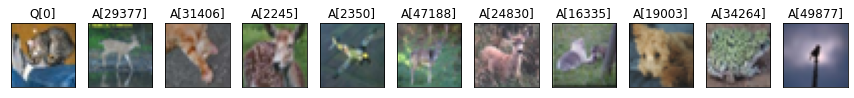

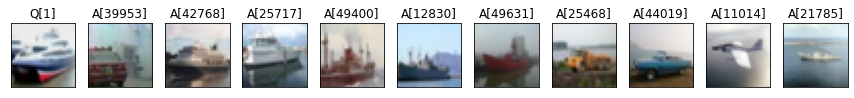

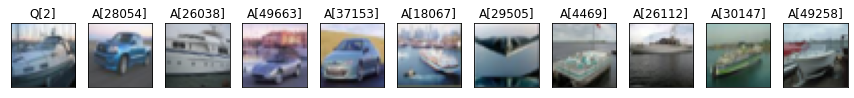

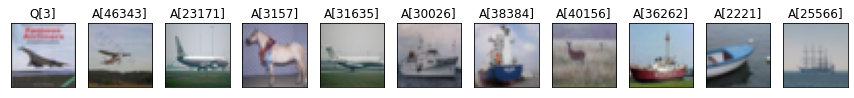

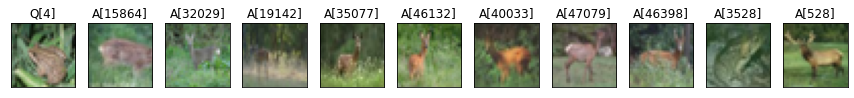

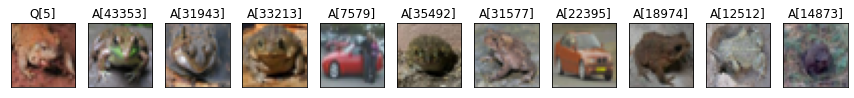

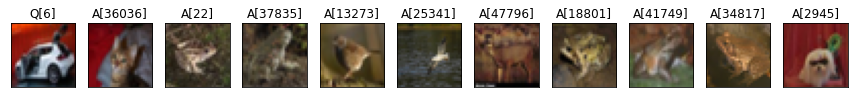

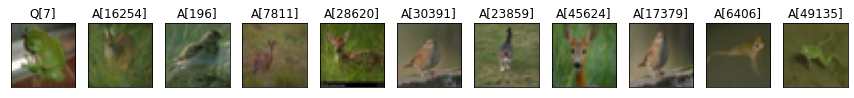

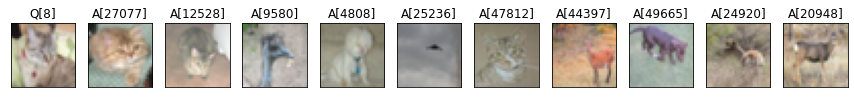

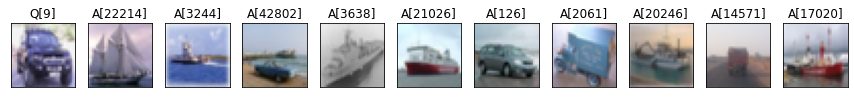

In [62]:
for i in range(10):
    show_search_images(train_dataset, test_dataset, indexes, i)

In [63]:
def merge_search_images(figs_path, dataset_name):
    files = glob.glob(f"{figs_path}/{dataset_name}_search_images_*.png")
    images = None
    for file in sorted(files):
        im = np.array(Image.open(file).convert('RGB'))
        h, w, c = im.shape
        im = im[120:h-130, 110:w-80, :] # trim
        if images is None:
            images = im
        else:
            images = np.append(images, im, axis=0)
    img = Image.fromarray(images)
    img.save(f"{figs_path}/{dataset_name}_search_images.png")
    return img

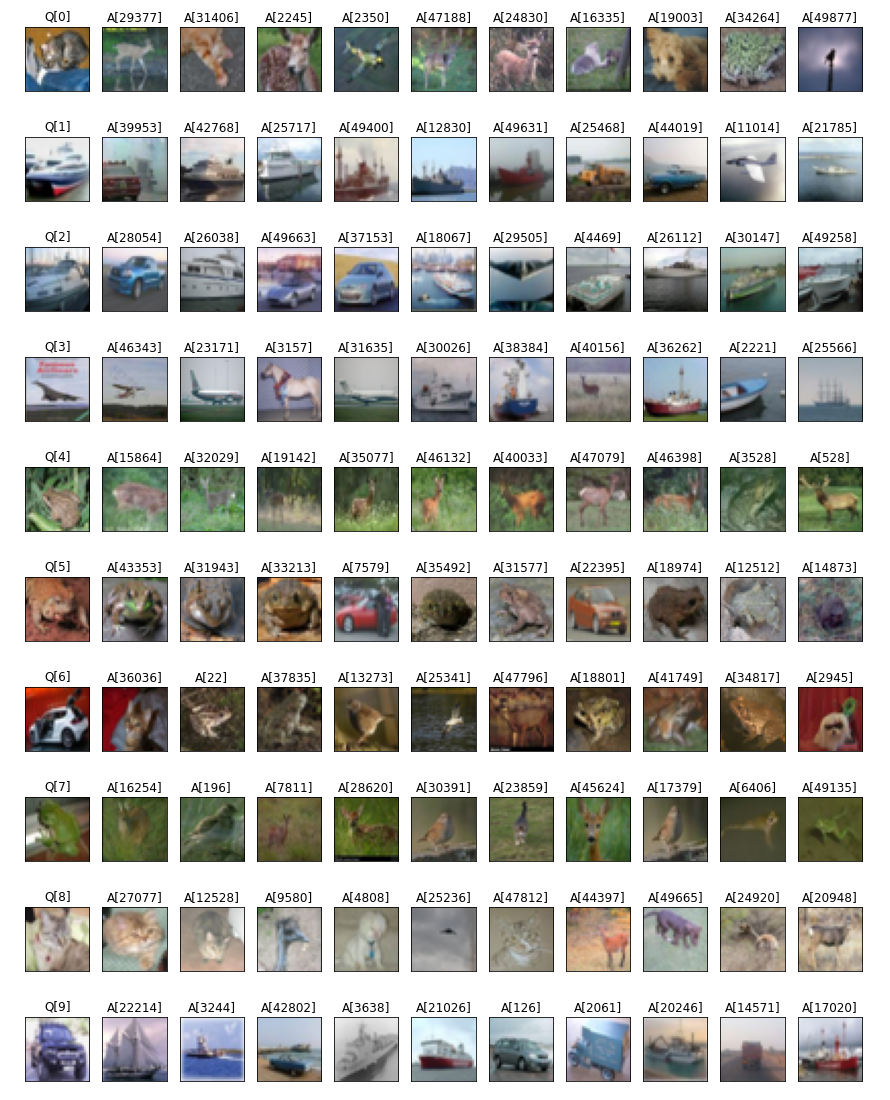

In [64]:
img = merge_search_images(figs_path, dataset_name)
img